In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import time
from statistics import median
from rsi import apply as rsi

from envs import SimpleTradingEnvironment
from agent import DQNAgent
from sklearn.preprocessing import StandardScaler

# Auto reload
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
# Generate data like a sine wave data
Fs = 2000
f = 5
x = np.arange(1000)
data = np.sin(2 * np.pi * f * x / Fs)

In [3]:
price_data = pd.DataFrame(data, columns=['price'])
price_data['price'] = (price_data['price'] * 100) + 300

# Add column for RSI to use as a feature for learning
price_data['rsi'] = rsi(price_data['price'])
environment_columns = ['rsi', 'price']

# Drop NA columns and reset index
price_data.dropna(inplace=True)
price_data.reset_index(drop=False, inplace=True)

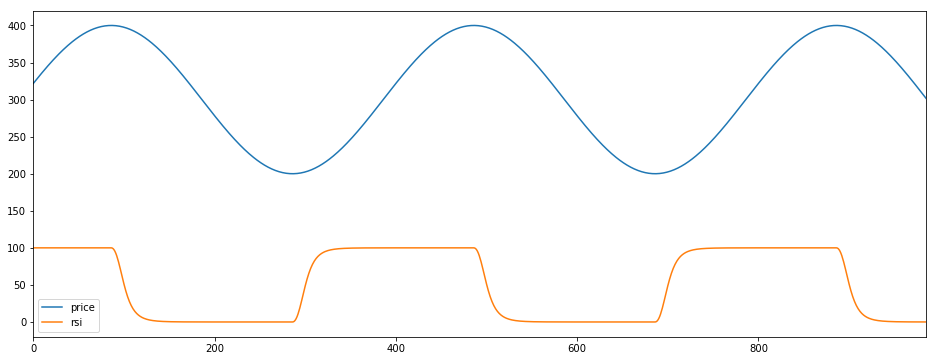

In [4]:
price_data[['price', 'rsi']].plot(figsize=(16,6))

In [5]:
train_size = round(len(price_data)/3*2)
train_data = price_data[:train_size].copy()
test_data = price_data[train_size:].copy()
print('train size {0}, test size {1}'.format(len(train_data), len(test_data)))

train size 657, test size 329


In [6]:
episode=2000
batch_size=2

In [7]:
low = []
high = []

# Add position range
low.append(0)
high.append(2)

# Add account balance range
low.append(0)
high.append(10000) # need to calculate this better

# Add range for environment columnns
low.extend([0] * len(environment_columns))
high.extend(train_data[environment_columns].max().tolist())

# Create a fit the scaler
scaler = StandardScaler()
scaler.fit([low, high])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [8]:
env = SimpleTradingEnvironment(
    price_data=train_data,
    environment_columns=environment_columns
)
state_size = env.observation_space.shape
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)
train_results = pd.DataFrame()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 1,315
Trainable params: 1,315
Non-trainable params: 0
_________________________________________________________________
None


## Train

In [9]:
for e in range(episode):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(".", end='')
            if (e + 1) % 20 == 0:
                print("")
                print("episode: {}/{}, median profit so far: {}".format(
                    e + 1, episode, median(train_results['account_balance'].tolist())))
            train_results = train_results.append(env._stats(), ignore_index=True)
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
    if (e + 1) % 10 == 0:
        agent.save('weights/{}-dqn.h5'.format(time.strftime('%Y%m%d%H%M')))



....................
episode: 20/2000, median profit so far: 523.1244888275064
....................
episode: 40/2000, median profit so far: 534.9345731345828
....................
episode: 60/2000, median profit so far: 542.2486343607561
....................
episode: 80/2000, median profit so far: 534.9345731345828
....................
episode: 100/2000, median profit so far: 542.2486343607561
....................
episode: 120/2000, median profit so far: 528.8461627029038
....................
episode: 140/2000, median profit so far: 528.8461627029038
....................
episode: 160/2000, median profit so far: 534.9345731345828
....................
episode: 180/2000, median profit so far: 542.3079700122622
....................
episode: 200/2000, median profit so far: 542.3079700122622
....................
episode: 220/2000, median profit so far: 542.3079700122622
....................
episode: 240/2000, median profit so far: 540.3844414356142
....................
episode: 260/2000, me

....................
episode: 1960/2000, median profit so far: 526.2430777227823
....................
episode: 1980/2000, median profit so far: 526.2430777227823
....................
episode: 2000/2000, median profit so far: 525.8163543716701


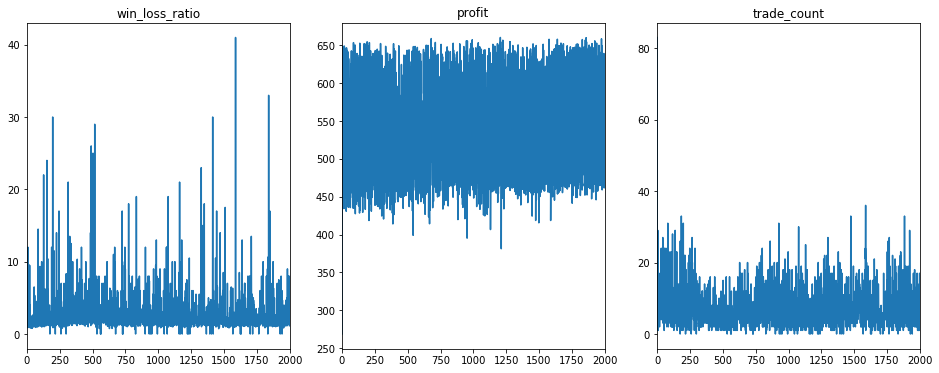

In [11]:
train_results['profit'] = train_results['account_balance']
columns_to_plot = ['win_loss_ratio', 'profit', 'trade_count']
fig, axes = plt.subplots(nrows=1,ncols=len(columns_to_plot), figsize=(16,6))
for i in range(len(columns_to_plot)):
    axes[i].title.set_text(columns_to_plot[i])
    train_results[columns_to_plot[i]].plot(ax=axes[i], subplots=True)
plt.show()

## Test

In [ ]:
state_size = env.observation_space.shape
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)
scaler = get_scaler(env)
test_portfolio_value = []

In [ ]:
# remake the env with test data
env = TradingEnv(test_data, initial_invest)
# load trained weights from latest saved
latest_weights_file = max(glob.glob('weights/*.h5'), key=os.path.getctime)
print('loading weights file: {0}'.format(latest_weights_file))
agent.load(latest_weights_file)
test_results = pd.DataFrame()

In [ ]:
for e in range(episode):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        state = next_state
        if done:
            test_results = test_results.append(env._stats(), ignore_index=True)
            break

In [ ]:
test_results['profit'] = test_results['value'] - initial_invest

In [ ]:
print('Median profit: {0} ({1}%)'.format(
    test_results['profit'].median(),
    test_results['profit'].median() / initial_invest * 100
))

In [ ]:
test_results.hist(column='profit', bins=60)